<a href="https://colab.research.google.com/github/PritishWadhwa/CM-Project/blob/master/Models/CM_fastai_Alexnet_Octmnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing the dataset and neccassary libraries. 

In [ ]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 7.8 MB/s 
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=ba1318f5e444968d28a8522fed0a12fc1145587789999982632be056b9b2f5bc
  Stored in directory: /root/.cache/pip/wheels/5b/eb/43/7295e71293b218ddfd627f935229bf54af9018add7fbb5aac6
Successfully built fire


In [ ]:
from fastai.vision.all import *
from fastai import *
import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO, Evaluator
import torchvision.transforms as transforms
from fastai.data.external import *
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image

In [ ]:
data_flag = 'octmnist'
download = True
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

In [ ]:
DataClass=getattr(medmnist, info['python_class'])

In [ ]:
train_dataset= DataClass(split='train',download=download)
val_dataset=DataClass(split='val',download=download)
test_dataset=DataClass(split='test',download=download)

  0%|          | 0/54938180 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz


In [ ]:
transform = T.Resize(224)

In [ ]:
data={'Image':[],"Labels":[],"is_valid":[]}

In [ ]:
for i in range(len(train_dataset)):
  data['Image'].append(train_dataset[i][0])
  data['Labels'].append(train_dataset[i][1][0])
  data['is_valid'].append(True)

for i in range(len(val_dataset)):
  data['Image'].append(val_dataset[i][0])
  data['Labels'].append(val_dataset[i][1][0])
  data['is_valid'].append(False)

In [ ]:
train_df=pd.DataFrame.from_dict(data)
train_df

,Image,Labels,is_valid
0,<PIL.Image.Image image mode=L size=28x28>,0,True
1,<PIL.Image.Image image mode=L size=28x28>,3,True
2,<PIL.Image.Image image mode=L size=28x28>,3,True
3,<PIL.Image.Image image mode=L size=28x28>,3,True
4,<PIL.Image.Image image mode=L size=28x28>,0,True
...,...,...,...
108304,<PIL.Image.Image image mode=L size=28x28>,0,False
108305,<PIL.Image.Image image mode=L size=28x28>,3,False
108306,<PIL.Image.Image image mode=L size=28x28>,0,False
108307,<PIL.Image.Image image mode=L size=28x28>,0,False


In [ ]:
train_df=train_df.sample(frac = 1).reset_index(drop=True)
train_df

,Image,Labels,is_valid
0,<PIL.Image.Image image mode=L size=28x28>,3,True
1,<PIL.Image.Image image mode=L size=28x28>,1,True
2,<PIL.Image.Image image mode=L size=28x28>,0,True
3,<PIL.Image.Image image mode=L size=28x28>,3,True
4,<PIL.Image.Image image mode=L size=28x28>,3,True
...,...,...,...
108304,<PIL.Image.Image image mode=L size=28x28>,0,True
108305,<PIL.Image.Image image mode=L size=28x28>,0,True
108306,<PIL.Image.Image image mode=L size=28x28>,2,True
108307,<PIL.Image.Image image mode=L size=28x28>,1,True


# Training Parameters and defining the model.

In [ ]:
def get_x(r):
    img=transform(r['Image'])
    img=np.asarray(img)
    return (img).astype(np.uint8)

def get_y(r):
    return r["Labels"]

In [ ]:
switch=True
block=""
if n_channels==1 and switch:
  block=(ImageBlock(cls=PILImageBW), CategoryBlock) # black & white
else:
  block=(ImageBlock(), CategoryBlock)

dblock = DataBlock(
    blocks=block,
    get_x=get_x,
    get_y=get_y,
    splitter=ColSplitter()
)

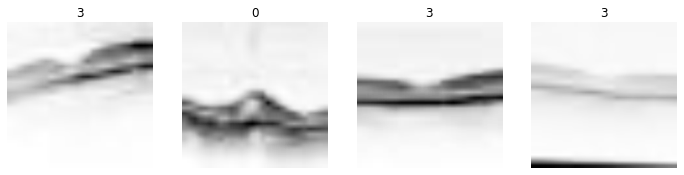

In [ ]:
dls = dblock.dataloaders(train_df, bs=32)
dls.show_batch(nrows=1, ncols=4)

In [ ]:
learn = vision_learner(dls, alexnet, metrics=accuracy)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
learn.fine_tune(10, base_lr=3e-3, freeze_epochs=4)  

epoch,train_loss,valid_loss,accuracy,time
0,0.919928,0.622960,0.792423,02:34
1,0.744310,0.571272,0.801245,02:24
2,0.642502,0.554178,0.808950,02:24
3,0.637422,0.585966,0.805452,02:23


epoch,train_loss,valid_loss,accuracy,time
0,0.445035,0.409376,0.857997,02:34
1,0.413857,0.407588,0.858377,02:27
2,0.389942,0.379495,0.868738,02:25
3,0.386031,0.416070,0.863619,02:26
4,0.315999,0.348230,0.879541,02:25
5,0.301168,0.357881,0.884968,02:25
6,0.275461,0.326570,0.889995,02:25
7,0.204921,0.303667,0.899381,02:26
8,0.166717,0.306655,0.901464,02:23
9,0.157732,0.298414,0.902941,02:24


#Evaluating the Model

In [ ]:
learn.metrics = accuracy
learn.validate() #(loss,accuracy)(for validation)

(#2) [0.2984143793582916,0.9029412269592285]

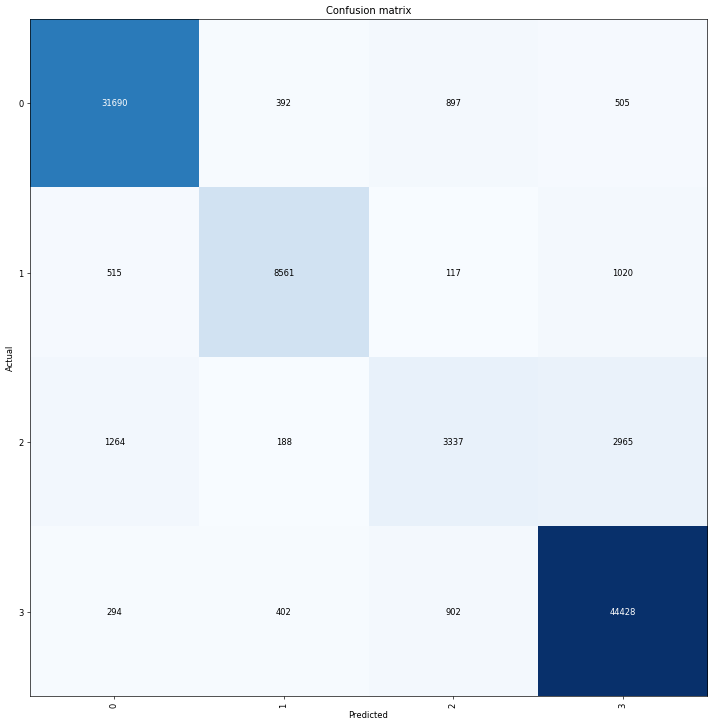

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60) # confusion matrix

In [ ]:
interp.most_confused(min_val=5) # prints (actual label,predicted label,freq of misclassified examples) (freq>=min_value)

[(2, 3, 2965),
 (2, 0, 1264),
 (1, 3, 1020),
 (3, 2, 902),
 (0, 2, 897),
 (1, 0, 515),
 (0, 3, 505),
 (3, 1, 402),
 (0, 1, 392),
 (3, 0, 294),
 (2, 1, 188),
 (1, 2, 117)]

In [ ]:
predictions=[]
labels=[]
for i in range(len(test_dataset)):
  img=np.asarray(transform(test_dataset[i][0]))
  img=(img).astype(np.uint8)
  pred,_,probs=learn.predict(img)
  predictions.append(int(pred))
  labels.append(test_dataset[i][1][0])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.60      0.98      0.74       250
           1       0.95      0.76      0.84       250
           2       0.93      0.20      0.33       250
           3       0.70      0.94      0.81       250

    accuracy                           0.72      1000
   macro avg       0.79      0.72      0.68      1000
weighted avg       0.79      0.72      0.68      1000

